### Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats as st

calls_df = pd.read_csv('./calls.csv')
internet_df = pd.read_csv('./internet.csv')
messages_df = pd.read_csv('./messages.csv')
tariffs_df = pd.read_csv('./tariffs.csv')
users_df = pd.read_csv('./users.csv')
# выведем основную информацию 
print("CALLS INFO \n")
print(calls_df.head())
print(calls_df.info())
print("\n")
print("INTERNET INFO \n")
print(internet_df.head())
print(internet_df.info())
print("\n")
print("MESSAGES INFO \n")
print(messages_df.head())
print(messages_df.info())
print("\n")
print("TARIIFS INFO \n")
print(tariffs_df.head())
print(tariffs_df.info())
print("\n")
print("USERS INFO \n")
print(users_df.head())
print(users_df.info())


CALLS INFO 

   Unnamed: 0      id   call_date  duration  user_id
0           0  1000_0  2018-07-25      0.00     1000
1           1  1000_1  2018-08-17      0.00     1000
2           2  1000_2  2018-06-11      2.85     1000
3           3  1000_3  2018-09-21     13.80     1000
4           4  1000_4  2018-12-15      5.18     1000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  202607 non-null  int64  
 1   id          202607 non-null  object 
 2   call_date   202607 non-null  object 
 3   duration    202607 non-null  float64
 4   user_id     202607 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 7.7+ MB
None


INTERNET INFO 

   Unnamed: 0  Unnamed: 0.1      id  mb_used session_date  user_id
0           0             0  1000_0   112.95   2018-11-25     1000
1           1             1  1000_1  1052.81  

В полученных датафреймах необходимо обработать колонки с датами, таким образом, чтобы из типа object они стали типом datetime.
Также заметим большую часть звонков с нулевой продолжительностью вызова. Выясним какую часть от общих данных они занимают

In [2]:
print(calls_df[calls_df["duration"] != 0.0].shape[0])
print(calls_df[calls_df["duration"] == 0.0].shape[0])

162994
39613


Нулевые звонки это пятая часть от всех звонков в таблице. Сложно предположить, с чем может быть связана ошибка с данными (например, если бы их число было ближе к половине, можно было бы предположить, что таким образом записались входящие звонки). \
У нас нет логичных альтернатив, как мы могли бы заполнить или обработать эти данные. Разумно будет избавится от них в следующем шаге.

### Шаг 2. Подготовьте данные
Обработаем колонки с датами и приведем их к формату datetime \
Выделим в датафреймах calls_df, internet_df, messages_df колонку с численным представление месяца. В дальнейшем по ней будет удобно группировать данные

In [3]:
# приведем колонки с датами в формат даты
calls_df["call_date"] = pd.to_datetime(calls_df["call_date"])
messages_df["message_date"] = pd.to_datetime(messages_df["message_date"])
internet_df["session_date"] = pd.to_datetime(internet_df["session_date"])
# в датафрейм добавим информацию о месяце как число для дальнейшей группировки
calls_df["month"] = calls_df["call_date"].dt.month
messages_df["month"] = messages_df["message_date"].dt.month
internet_df["month"] = internet_df["session_date"].dt.month
calls_df = calls_df[calls_df["duration"] != 0]


#### Подсчет средних затраченных пользователем минут, смс и мегабайт трафика по месяцам
Выделим функции для необходимых расчетов в отдельную ячейку
- get_row_revenue - вычисление выручки с пользователя (основная формула)
- get_user_revenue - вычисление по выручки по всем колонкам через функцию get_row_revenue
- get_pivot_table_info - вычисление сводной таблицы по месяцам и пользовательскому id
- merge_info_func - функция объединения сводных таблиц в единый датафрейм. В полученном датафрейме будет хранится сводная информация по затраченным пользователем лимитов тарифа
- get_tariff_row - получение данных по тарифу пользователя 

In [4]:
# основные вычисления по полученным данным
def get_row_revenue(user_spent, tarif_limit, fine_mult, divide_by):
    if (user_spent > tarif_limit):
        return math.ceil((user_spent - tarif_limit) / divide_by) * fine_mult
    return 0
# функция для вычисления суммарной выручки по колонке
def get_user_revenue(spending_row, tariff_row):
    total_revenue = 0
    columns = spending_row.index.values
    # если у пользователя есть переплата по колонке отправляем ее на вычисление
    if (("minute_spend" in columns)):
        total_revenue += get_row_revenue(spending_row["minute_spend"], tariff_row["minutes_included"], tariff_row["rub_per_minute"], 1)
    if (("message_sent" in columns)):
        total_revenue += get_row_revenue(spending_row["message_sent"], tariff_row["messages_included"], tariff_row["rub_per_message"], 1)
    if (("mb_spent_by_monts" in columns)):
        total_revenue += get_row_revenue(spending_row["mb_spent_by_monts"], tariff_row["mg_per_month_included"], tariff_row["rub_per_gb"], 1024)
    return total_revenue

# функция объединения данных
def merge_info_func(df_orig, df_new, columns):
    if (df_orig.empty == False):
        if (df_new.empty == False):
            return df_orig.merge(df_new, how='left', on = columns)
        else:
            return df_orig
    return df_new
# получим строку с тарифом пользователя

def get_tariff_row(tarrif_name):
    return tariffs_df.loc[tariffs_df["tariff_name"] == tarrif_name].iloc[0]

# получим сводную таблицу по заданным параметрам
def get_pivot_table_info(df, values, aggfunc, column_name):
    new_pivot = pd.pivot_table(df, values=values, index=["user_id",'month'], aggfunc=aggfunc)
    if (new_pivot.shape[0] > 0):
        new_pivot.columns = column_name
    return new_pivot

#### aggregate_info описание функции
Возьмем каждое значение датафрейма users_df и прогоним его через функцию add_new_info. \
В функции мы получим связанные с пользователем затраченные в среднем смс, звонки и мегабайты и сгруппируюм их по месяцам. \
Объединим полученные данные через по месяцам. \
В связи с тем, что пользователь мог подключить тариф не в начале месяца, а отключить не в самом конце (или срез данных приходится не на самый посдедний день месяца) данные по первому и последнему месяцу пользования тарифа ненадежны (например пользователь подключил тариф 25 числа и затратил совсем немного месячного лимита). Таким образом мы немного теряем в данных, однаком получаем более четкие выборки. \
Получим выручку по каждому месяцу \
Объединим все пользовательские данные в едином датафрейме и получим сгруппированные по пользователю и по месяцу датафрейм, где в качестве ключей выступают id пользователя и месяц наблюдения, а в качестве значений среднее затраченное по мегабайтам, минутам, количеству сообщений. Также добавим в датафрейм информацию о тарифе и городе пользователя, эти дагнные пригодятся нам позднее.

In [5]:
# массив для хранения аггрегированных данных по пользователю 
agg_info_array = []

# функция генерирующая новый датафрейм с информацией о использовании тарифа пользователем по месяцам
def aggregate_info(row):    
    user_id = row["user_id"]
    # получим связанные с id пользователя датафреймы по звонкам, сообщениям и интернету  
    user_calls = calls_df[calls_df["user_id"] == user_id]
    user_messages = messages_df[messages_df["user_id"] == user_id]
    internet_by_user = internet_df[internet_df["user_id"] == user_id]
    # тариф пользователя
    user_tariff = users_df[users_df["user_id"] == user_id].iloc[0]["tariff"]
    # строка с информацией о тарифе пользователя
    tariff_row = get_tariff_row(user_tariff)
    # сводная таблица с информацией о количестве звонков сделанных пользователем, и потраченных минут
    calls_pivot = get_pivot_table_info(user_calls, 'duration', ["count", "sum"], ["calls_made", "minute_spend"])
    # сводная таблица с информацией о количестве отправленных сообщений пользователя
    messages_pivot = get_pivot_table_info(user_messages, 'id', ["count"], ["message_sent"])
    # сводная таблица с информацией о затраченных пользователем мегабайт
    internet_pivot = get_pivot_table_info(internet_by_user, 'mb_used', ["sum"], ["mb_spent_by_monts"])
    # получим общий датафрейм с аггрегированной информацией по месяцам
    merged_info = pd.DataFrame()
    merged_info = merge_info_func(merged_info, calls_pivot, ["user_id","month"])
    merged_info = merge_info_func(merged_info, messages_pivot, ["user_id","month"])
    merged_info = merge_info_func(merged_info, internet_pivot, ["user_id","month"])
    if ((merged_info.empty == False) & (merged_info.shape[0] > 2)):
        merged_info.drop(merged_info.tail(1).index,inplace=True)
        merged_info.drop(merged_info.head(1).index,inplace=True)
        # посчитаем выручку от пользователя по месяцам
        merged_info["total_revenue"] = merged_info.apply(lambda x: get_user_revenue(x, tariff_row), axis = 1)
        # добавляем информацию о тарифе и городе пользователя
        merged_info["tariff"] = row["tariff"]
        merged_info["city"] = row["city"]
        new_row = pd.DataFrame(merged_info)
        # если полученные аггрегированные данные не пустые добавляем их в общий набор
        agg_info_array.append(merged_info)

# получим единый, аггрегированный датафрейм с информацией по всем пользователям
users_df.apply(aggregate_info, axis=1)
agg_df = pd.concat(agg_info_array, sort=False)

agg_df.head()

calls_made  minute_spend  message_sent  mb_spent_by_monts  \
user_id month                                                              
1000    6            28.0        158.90          60.0           23233.77   
        7            41.0        318.80          75.0           14003.64   
        8            42.0        389.87          81.0           14055.93   
        9            46.0        440.14          57.0           14568.91   
        10           44.0        328.45          73.0           14702.49   

               total_revenue tariff       city  
user_id month                                   
1000    6                  0  ultra  Краснодар  
        7                  0  ultra  Краснодар  
        8                  0  ultra  Краснодар  
        9                  0  ultra  Краснодар  
        10                 0  ultra  Краснодар

По итогу получим отдельный датафрейм с списком всех необходимых для дальнейших расчетов данных.

### Шаг 3. Проанализируйте данные

Колонка minute_spend
Для тарифа ultra среднее: 556.9330988023953. Для тарифа smart среднее 422.62533548387097 
Для тарифа ultra дисперсия: 72157.74915814915. Для тарифа smart дисперсия 25381.943971449673 
Для тарифа ultra стандартное распределение: 268.62194466973307. Для тарифа smart распределение 159.3171176347654 
Колонка message_sent
Для тарифа ultra среднее: 63.87160940325497. Для тарифа smart среднее 41.37795857988166 
Для тарифа ultra дисперсия: 2049.394717876143. Для тарифа smart дисперсия 697.3677743639382 
Для тарифа ultra стандартное распределение: 45.2702409743547. Для тарифа smart распределение 26.407721870012534 
Колонка mb_spent_by_monts
Для тарифа ultra среднее: 21142.497503649633. Для тарифа smart среднее 17373.643277527364 
Для тарифа ultra дисперсия: 84756761.73352958. Для тарифа smart дисперсия 22543865.91932824 
Для тарифа ultra стандартное распределение: 9206.343559390427. Для тарифа smart распределение 4748.0381126659295 
Колонка total_revenue
Для тарифа ultra ср

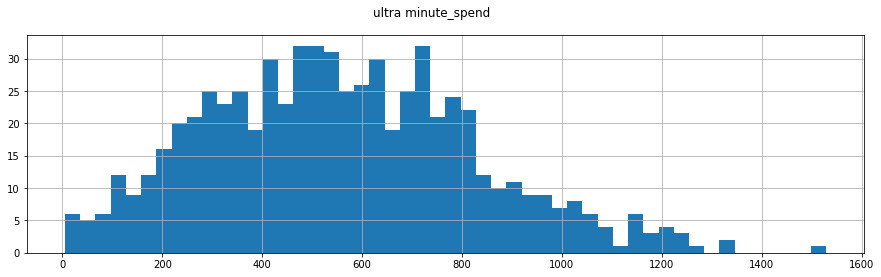

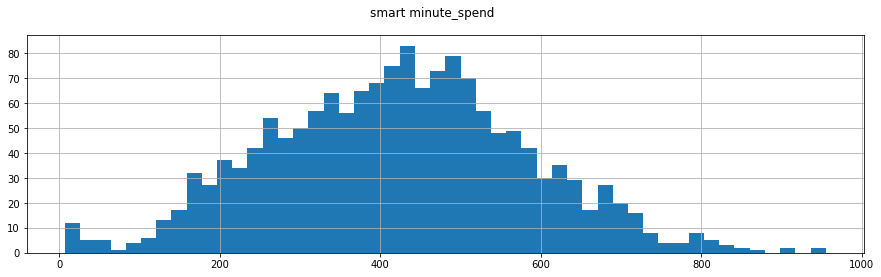

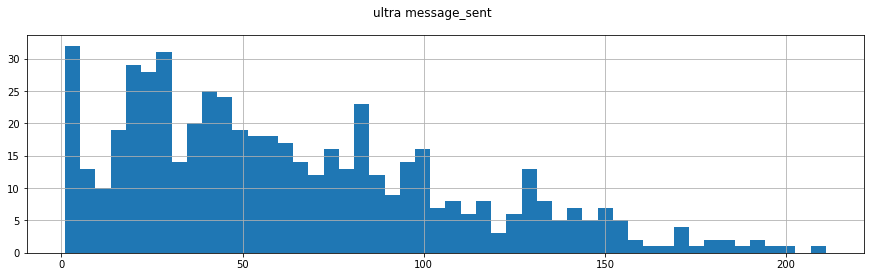

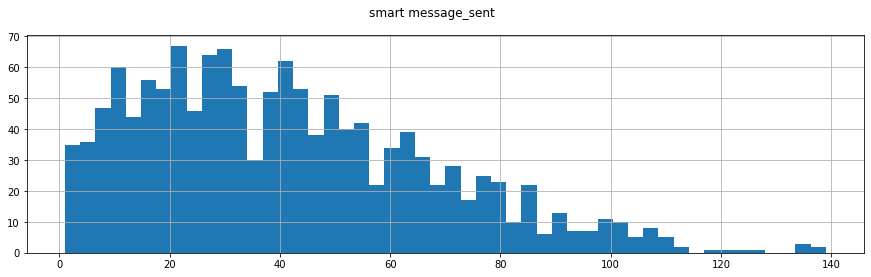

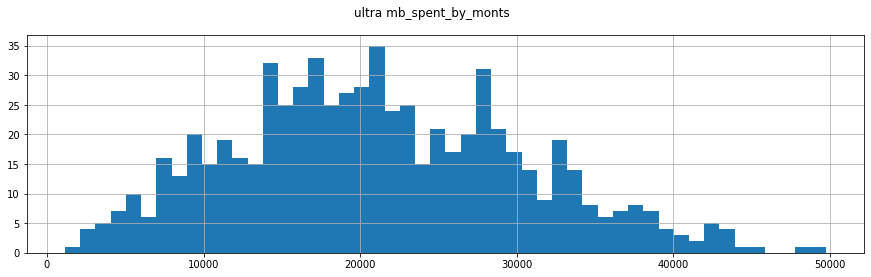

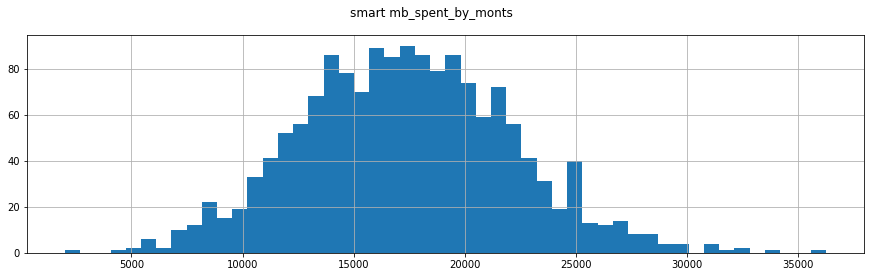

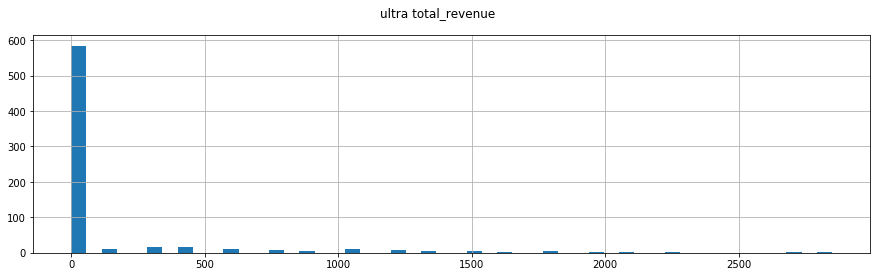

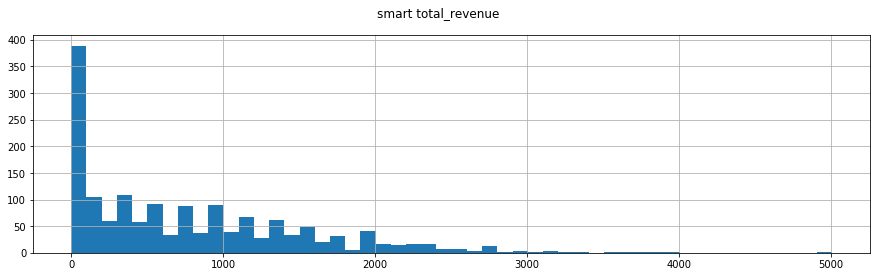

In [6]:
# функция для отображения гистограмм
def hist_draw(df, column, title):
    df[column].hist(figsize=(15,4), bins=50)
    plt.suptitle(title, fontsize='large')
    plt.show()
# функция вывода информации (среднее, дисперсия, распределение) по разным тарифам
def get_tarrif_info(ultra_df, smart_df, column):
    print("Колонка", column)
    print("Для тарифа ultra среднее: {}. Для тарифа smart среднее {} ".format(ultra_df[column].mean(), smart_df[column].mean()))
    print("Для тарифа ultra дисперсия: {}. Для тарифа smart дисперсия {} ".format(ultra_df[column].var(), smart_df[column].var()))
    print("Для тарифа ultra стандартное распределение: {}. Для тарифа smart распределение {} ".format(ultra_df[column].std(), smart_df[column].std()))

# получим два датафрейма с выборкой по имени тарифа
ultra_df = agg_df[agg_df["tariff"] == "ultra"]
smart_df = agg_df[agg_df["tariff"] == "smart"]

# информация (среднее, дисперсия, распределение) по основным колонкам 
get_tarrif_info(ultra_df, smart_df, "minute_spend")
get_tarrif_info(ultra_df, smart_df, "message_sent")
get_tarrif_info(ultra_df, smart_df, "mb_spent_by_monts")
get_tarrif_info(ultra_df, smart_df, "total_revenue")

# гистограммы по основным колонкам 
hist_draw(ultra_df, "minute_spend", "ultra minute_spend")
hist_draw(smart_df, "minute_spend", "smart minute_spend")
hist_draw(ultra_df, "message_sent", "ultra message_sent")
hist_draw(smart_df, "message_sent", "smart message_sent")
hist_draw(ultra_df, "mb_spent_by_monts", "ultra mb_spent_by_monts")
hist_draw(smart_df, "mb_spent_by_monts", "smart mb_spent_by_monts")
# дополнительно изучим для дальнейших наблюдений
hist_draw(ultra_df, "total_revenue", "ultra total_revenue")
hist_draw(smart_df, "total_revenue", "smart total_revenue")

#### Выводы

|               | smart Среднее | ultra Среднее | smart дисперсия | ultra  дисперсия | smart ст. отклонение | ultra  ст. отклонение |
|:-------------:|:-------------:|:-------------:|:---------------:|:----------------:|:--------------------:|:---------------------:|
|  Минуты разговора  |      423      |      557      |      25381      |       72157      |          159         |          268          |
|  Отправленных сообщений |       41      |       63      |       697       |       2049       |          26          |           45          |
| Мегабайт |     17373     |     21142     |     22543865    |     84756761     |         4748         |          9206         |


#### Пакет минут
Согласно данным:
- гистограмма тарифа смарт близка к нормальному распределению, и достигает пика немного не доходя до предельного лимита по тарифу (500)
- гистограмма тарифа ультра скошенна вправо, но не переступает лимит па тарифу (3000)
- среднее этих двух тарифов отличается не столь сильно, 423/557, как их стандартное распределение 159/268 (почти в два раза). Из этого можем сделать вывод, что пользователи тарифа смарт используют минуты более сбалансировано, тогда как пользователи тарифа ультра либо используют минуты по разным сценариям

#### Пакет смс
Использование пакета смс между двумя тарифами отличается незначительно. Гистограммы обоих тарифов скошены вправо.  Можно сказать, что пользователи тарифа ультра в силу большего лимита отправляют сообщения немного активнее. \
Также можно отметить, что у пользователей тарифа ультра чаще встречаются значения близкие к нулю. Будем считать, что в тарифе ультра пакет смс не является важным лимитом для пользователей.
#### Пакет мегабайт
В данном случае наблюдаем сценарий почти идентичный гистограммам для пакета минут. Тогда как у тарифа смарт гистограмма близка к нормальному распределению, для пользователей тарифа ультра гистограмма скошена вправо. Можно заметить, что пользователи тарифа ультра в силу повышенного лимита крайне редко преступают лимиты трафика, тогда как для большинство пользователей тарифа смарт превышают ежемесячный лимит .

#### Шаг 4. Проверьте гипотезы

Необходимо выяснить различаются ли между собой выручка между пользователями тарифов смарт и ультра, а также между жителями Москвы и других регионов. \
Во первых, отметим, что для обоих гипотез нам необходимо выяснить различие выручек, при этом не обязательно выяснять в большую или меньшую сторону. \
Во вторых данные по выручке будут лежать в двух разных, независимых выборках. \
Для получения выборки из совокупности данных используем функцию sample. Возьмем выборку в 30 элементов для каждой из гипотез. \
Учитывая, что нам необходимо обработать выборки и выяснить степень равенства среднего будем использовать метод scipy.stats.ttest_ind \
В качестве порогового значения в обоих гипотезах укажем 5%

Сформулируем нулевую теорию следующим образом: выручка тарифов смарт и ультра схожести, тогда альтернативная гипотеза будет говорить о различии выручки двух тарифов.

In [10]:
alpha = .01

tariff_results = st.ttest_ind(
    ultra_df["total_revenue"], 
    smart_df["total_revenue"], equal_var = False)

print('p-значение:', tariff_results.pvalue)
# если полученное значение меньше уровня критической значимости опровергнем теорию
if (tariff_results.pvalue < alpha):
    print("Опровергаем гипотезу о схожести выручки пользователей тарифов «Ультра» и «Смарт»")
else:
    print("Не удалось опровергнуть гипотезу о схожести выручки пользователей тарифов «Ультра» и «Смарт»")



p-значение: 3.477647777668263e-136
Опровергаем гипотезу о схожести выручки пользователей тарифов «Ультра» и «Смарт»


Полученное в результате проверки гипотезы значение, указывает на различие выручки между тарифами смарт и ультра

In [17]:
final_df_moscow = agg_df[(agg_df["city"] == "Москва")]
final_df_else = agg_df[(agg_df["city"] != "Москва")]
# рассчитаем p-значение


print("Для тарифа ultra дисперсия: {}. Для тарифа smart дисперсия {} ".format(final_df_moscow["total_revenue"].var(), final_df_else["total_revenue"].var()))



cities_results = st.ttest_ind(final_df_moscow["total_revenue"],
final_df_else["total_revenue"], equal_var = False)

print('p-значение:', cities_results.pvalue)
# если полученное значение меньше уровня критической значимости опровергнем теорию
if (cities_results.pvalue < alpha):
    print("Опровергаем гипотезу о схожести выручки пользователей из Москвы и из других регионов")
else:
    print("Не удалось опровергнуть гипотезу о схожести выручки пользователей из Москвы и из других регионов")

Для тарифа ultra дисперсия: 428896.48037359584. Для тарифа smart дисперсия 555818.6416951491 
p-значение: 0.025505014095661964
Не удалось опровергнуть гипотезу о схожести выручки пользователей из Москвы и из других регионов


Полученное в результате проверки гипотезы значение, указывает на схожесть выручки между абонентами из Москвы и других городов

### Шаг 5. Напишите общий вывод

1) Тариф смарт подходит для людей с сбалансированным использованием минут вызова и смс. Это значит, что для подавляющего большинства предоставленного лимита достаточно для ежемесячного пользования. Однако для пользователей было бы привлекательно, если верхний лимит трафика повысить до 20 гб. Таким образом покрылась бы большая часть использования интернета пользователями.  
2) Тариф ультра привлекателен для людей часто использующих интернет в больших объемах и мобильной связью. Большинству пользователей предоставленных лимитов достаточно \
3) Наблюдая как отличаются между собой значения стандартного отклонения для минут и интернет трафика, относительно среднего потребления для тарифов ультра и смарт (среднее почти не отличается, но ст. отклонения для ультра больше почти в два раза) можно сделать вывод, что тарифом ультра пользуются две группы пользователей, те кому в первую очередь привлекателен лимит трафика, но не интересна мобильная связь и наоборот. Возможно стоит предложить пользователям альтернативы в виде тарифа с высоким лимитом трафика и отдельно с большим пакетом минут. \
4) Опровергнув гипотезу, о схожести выручки тарифов Ультра и Смарт, а также изучив гистограмму с выручкой пользователй разных тарифов, можем предположить, что пользователи тарифа Смарт недооценивают свои запросы на интернет и мобильную связь в месяц и могут оказаться в ситуации, когда им было выгоднее использовать тариф ультра. Возможно стоит разработать эвристику анализирующую затраты пользователя и предлагающую ему альтернативный тарифный план. \
5) Подтвердив гипотезу о схожести выручки для пользователей из Москвы и других регионов, сделаем вывод о схожести шаблонов использования мобильной связи и интернета вне зависимости от места проживания и отсутствия необходимости изменять стоимость тарифа в зависимости от региона проживания.